In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1) 
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
import pickle
from collections import Counter
from itertools import chain
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk

<ipython-input-1-a15040ea8f3c>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
df = pd.read_csv("tweets_noemoticon.csv", encoding = 'latin-1', header = None)

In [5]:
df.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [6]:
df[0] = df[0].apply(lambda x: 1 if x==4 else x)

In [7]:
# rename columns
df = df.rename(columns={5: 'text', 0: 'target', 2: 'timestamp', 4: 'username'})

In [8]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishabaitemirova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aishabaitemirova/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<AxesSubplot:xlabel='target', ylabel='count'>

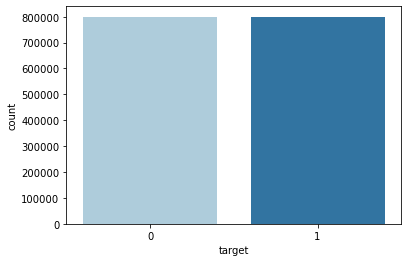

In [9]:
sns.set_palette("Paired")
sns.countplot(x= 'target',data=df)

In [10]:
# lowercase and remove punctuation
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]+', '')

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [13]:
df.columns

Index(['target', 1, 'timestamp', 3, 'username', 'text'], dtype='object')

In [15]:
def lemmatize_text(text):

    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in w_tokenizer.tokenize(text)]

# lemmatize text
df['text_lemmatized'] = df.text.apply(lemmatize_text)

In [16]:
df.head(5)

,target,1,timestamp,3,username,text,text_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats a bummer you shoulda got david carr of third day to do it d,"[switchfoot, httptwitpiccom2y1zl, awww, thats, a, bummer, you, shoulda, get, david, carr, of, third, day, to, do, it, d]"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,"[be, upset, that, he, cant, update, his, facebook, by, texting, it, and, might, cry, a, a, result, school, today, also, blah]"
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball managed to save 50 the rest go out of bounds,"[kenichan, i, dive, many, time, for, the, ball, manage, to, save, 50, the, rest, go, out, of, bound]"
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, on, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im mad why am i here because i cant see you all over there,"[nationwideclass, no, it, not, behaving, at, all, im, mad, why, be, i, here, because, i, cant, see, you, all, over, there]"


In [17]:
# drop columns that are not going to be used for making predictions
df.drop(columns= 1, axis=1, inplace=True)
df.drop(columns= 3, axis=1, inplace=True)

In [18]:
# remove hashtags and mentions
df['text'] = df['text'].apply(lambda t: re.sub('@[^ ]+|#[^ ]+', '', t))

In [19]:
# import stopwords from nltk
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
# append some additional stopwords to the nltk stopwords list
stopwords.append('shoulda')
stopwords.append('im')

In [21]:
# remove stopwords
df['text_nostopwords'] = df['text_lemmatized'].apply(lambda x: ' '.join([word for word in x if word not in (stopwords)]))

In [22]:
df.head(5)

,target,timestamp,username,text,text_lemmatized,text_nostopwords
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats a bummer you shoulda got david carr of third day to do it d,"[switchfoot, httptwitpiccom2y1zl, awww, thats, a, bummer, you, shoulda, get, david, carr, of, third, day, to, do, it, d]",switchfoot httptwitpiccom2y1zl awww thats bummer get david carr third day
1,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,"[be, upset, that, he, cant, update, his, facebook, by, texting, it, and, might, cry, a, a, result, school, today, also, blah]",upset cant update facebook texting might cry result school today also blah
2,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,kenichan i dived many times for the ball managed to save 50 the rest go out of bounds,"[kenichan, i, dive, many, time, for, the, ball, manage, to, save, 50, the, rest, go, out, of, bound]",kenichan dive many time ball manage save 50 rest go bound
3,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, on, fire]",whole body feel itchy like fire
4,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,nationwideclass no its not behaving at all im mad why am i here because i cant see you all over there,"[nationwideclass, no, it, not, behaving, at, all, im, mad, why, be, i, here, because, i, cant, see, you, all, over, there]",nationwideclass behaving mad cant see


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1600000 non-null  int64 
 1   timestamp         1600000 non-null  object
 2   username          1600000 non-null  object
 3   text              1600000 non-null  object
 4   text_lemmatized   1600000 non-null  object
 5   text_nostopwords  1600000 non-null  object
dtypes: int64(1), object(5)
memory usage: 73.2+ MB


In [24]:
# do stemming
stemmer = SnowballStemmer('english')
df['text_stemmed'] =df['text_nostopwords'].apply(lambda x: stemmer.stem(x))

In [48]:
df.head(5)

,target,timestamp,username,text,text_lemmatized,text_nostopwords,text_stemmed
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats a bummer you shoulda got david carr of third day to do it d,"[switchfoot, httptwitpiccom2y1zl, awww, thats, a, bummer, you, shoulda, get, david, carr, of, third, day, to, do, it, d]",switchfoot httptwitpiccom2y1zl awww thats bummer get david carr third day,switchfoot httptwitpiccom2y1zl awww thats bummer get david carr third day
1,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,"[be, upset, that, he, cant, update, his, facebook, by, texting, it, and, might, cry, a, a, result, school, today, also, blah]",upset cant update facebook texting might cry result school today also blah,upset cant update facebook texting might cry result school today also blah
2,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,kenichan i dived many times for the ball managed to save 50 the rest go out of bounds,"[kenichan, i, dive, many, time, for, the, ball, manage, to, save, 50, the, rest, go, out, of, bound]",kenichan dive many time ball manage save 50 rest go bound,kenichan dive many time ball manage save 50 rest go bound
3,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, on, fire]",whole body feel itchy like fire,whole body feel itchy like fir
4,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,nationwideclass no its not behaving at all im mad why am i here because i cant see you all over there,"[nationwideclass, no, it, not, behaving, at, all, im, mad, why, be, i, here, because, i, cant, see, you, all, over, there]",nationwideclass behaving mad cant see,nationwideclass behaving mad cant se


In [49]:
len(df)

1600000

In [50]:
# check if there are any duplicates in the dataset
duplicates = df.loc[df.duplicated(subset=['text_nostopwords'])]

In [51]:
duplicates.shape

(49873, 7)

In [52]:
duplicates['text_nostopwords'].value_counts()

work                                                                                                    695
good morning                                                                                            536
headache                                                                                                533
                                                                                                        391
tire                                                                                                    351
                                                                                                       ... 
mkarolian car sound like fall apart                                                                     1  
raihanamcfly lol salivary gland frm little fly way alisondrama queen oh ur brain hurt new brain grow    1  
happy mother day tweet mom                                                                              1  
well door hung need painting

In [53]:
type(duplicates)

pandas.core.frame.DataFrame

In [111]:
duplicates_updated = duplicates.groupby('text_nostopwords').filter(lambda x : len(x)>250)

In [112]:
len(duplicates_updated['text_nostopwords'])

3646

In [113]:
duplicates_updated

,target,timestamp,username,text,text_lemmatized,text_nostopwords,text_stemmed
870,0,Mon Apr 06 23:21:02 PDT 2009,flashbrother,work again,"[work, again]",work,work
1669,0,Tue Apr 07 00:17:48 PDT 2009,88claytions,doing homework,"[do, homework]",homework,homework
1985,0,Tue Apr 07 00:42:39 PDT 2009,markbrown83,off to work,"[off, to, work]",work,work
2997,0,Tue Apr 07 02:01:04 PDT 2009,amielia_1991,homework,[homework],homework,homework
3367,0,Tue Apr 07 02:31:15 PDT 2009,jorja_xoxo,doing homework,"[do, homework]",homework,homework
...,...,...,...,...,...,...,...
1599234,1,Tue Jun 16 08:24:29 PDT 2009,Dannymassacur,good morning,"[good, morning]",good morning,good morn
1599326,1,Tue Jun 16 08:24:49 PDT 2009,Xplizzit,good morning,"[good, morning]",good morning,good morn
1599338,1,Tue Jun 16 08:26:36 PDT 2009,rooster3310,good morning,"[good, morning]",good morning,good morn
1599450,1,Tue Jun 16 08:28:39 PDT 2009,asiatikah,good morning,"[good, morning]",good morning,good morn


In [114]:
duplicates_updated['text_nostopwords'].value_counts()

work            695
good morning    536
headache        533
                391
tire            351
rain            323
goodnight       282
tummy hurt      270
homework        265
Name: text_nostopwords, dtype: int64

In [115]:
duplicates_0 = duplicates_updated[duplicates_updated['target'] == 0]

In [116]:
duplicates_0['text_nostopwords'].value_counts()

work            577
headache        533
tire            344
rain            283
tummy hurt      269
homework        252
                209
goodnight       28 
good morning    6  
Name: text_nostopwords, dtype: int64

<AxesSubplot:>

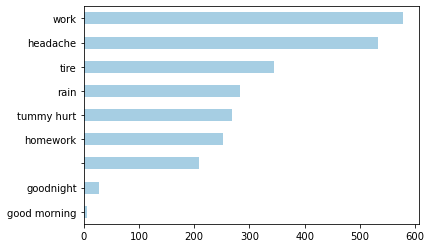

In [117]:
duplicates_0['text_nostopwords'].value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

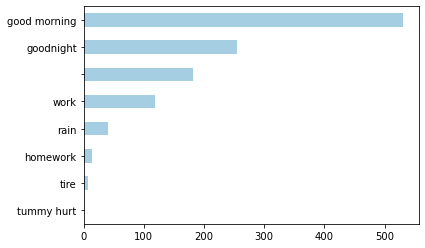

In [121]:
duplicates_1['text_nostopwords'].value_counts().sort_values().plot(kind = 'barh')

In [118]:
duplicates_1 = duplicates_updated[duplicates_updated['target'] == 1]

In [119]:
duplicates_1

,target,timestamp,username,text,text_lemmatized,text_nostopwords,text_stemmed
800099,1,Mon Apr 06 22:27:43 PDT 2009,kathrynsuzanne,goodnight,[goodnight],goodnight,goodnight
801076,1,Mon Apr 06 23:17:56 PDT 2009,Brandon128,goodnight,[goodnight],goodnight,goodnight
801214,1,Mon Apr 06 23:23:23 PDT 2009,kasey__marie,goodnight,[goodnight],goodnight,goodnight
802871,1,Tue Apr 07 00:48:55 PDT 2009,KarynShanks,is working,"[be, work]",work,work
802911,1,Tue Apr 07 00:52:54 PDT 2009,Ninkey84,at work again,"[at, work, again]",work,work
...,...,...,...,...,...,...,...
1599234,1,Tue Jun 16 08:24:29 PDT 2009,Dannymassacur,good morning,"[good, morning]",good morning,good morn
1599326,1,Tue Jun 16 08:24:49 PDT 2009,Xplizzit,good morning,"[good, morning]",good morning,good morn
1599338,1,Tue Jun 16 08:26:36 PDT 2009,rooster3310,good morning,"[good, morning]",good morning,good morn
1599450,1,Tue Jun 16 08:28:39 PDT 2009,asiatikah,good morning,"[good, morning]",good morning,good morn


In [120]:
duplicates_1_list = duplicates_1['text_nostopwords'].value_counts()

In [34]:
remove_n = 1000000

In [35]:
drop_indices = np.random.choice(df.index, remove_n, replace=False)

In [36]:
drop_indices

array([ 656952,  630773,  842401, ...,  266065,  450735, 1490301])

In [37]:
df_subset = df.drop(drop_indices)

In [38]:
v=df_subset['text_stemmed'].str.split().tolist()

In [39]:
c=Counter(chain.from_iterable(v))

In [40]:
c

Counter({'switchfoot': 11,
         'httptwitpiccom2y1zl': 1,
         'awww': 1988,
         'thats': 11247,
         'bummer': 314,
         'get': 63961,
         'david': 905,
         'carr': 24,
         'third': 315,
         'day': 38074,
         'need': 15458,
         'hug': 1891,
         'tatiana_k': 5,
         'nope': 894,
         'didnt': 10153,
         'twittera': 5,
         'que': 217,
         'muera': 1,
         'caregiving': 2,
         'couldnt': 2457,
         'bear': 390,
         'watch': 16182,
         'thought': 4677,
         'ua': 13,
         'loss': 387,
         'embarrass': 146,
         'octolinz16': 1,
         'count': 620,
         'idk': 886,
         'either': 1336,
         'never': 6413,
         'talk': 5524,
         'anymor': 1171,
         'smarrison': 1,
         'wouldve': 225,
         'first': 6154,
         'gun': 199,
         'really': 18135,
         'though': 8742,
         'zac': 107,
         'snyders': 1,
         'doucheclo

In [41]:
# remove all words that appear less than 10 times in the whole dataset
df_subset['low_removed']=[' '.join([j for j in i if c[j] > 10]) for i in v]

In [42]:
df_subset.head(1)

,target,timestamp,username,text,text_lemmatized,text_nostopwords,text_stemmed,low_removed
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats a bummer you shoulda got david carr of third day to do it d,"[switchfoot, httptwitpiccom2y1zl, awww, thats, a, bummer, you, shoulda, get, david, carr, of, third, day, to, do, it, d]",switchfoot httptwitpiccom2y1zl awww thats bummer get david carr third day,switchfoot httptwitpiccom2y1zl awww thats bummer get david carr third day,switchfoot awww thats bummer get david carr third day


In [43]:
df_subset.isna().sum()

target              0
timestamp           0
username            0
text                0
text_lemmatized     0
text_nostopwords    0
text_stemmed        0
low_removed         0
dtype: int64

In [44]:
df_subset = df_subset.dropna()

In [45]:
# save the subset into csv file
df_subset.to_csv('new_file_jan24.csv')